In [230]:
%matplotlib inline

import re
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import psycopg2
import seaborn as sbn
import requests
import textatistic
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
py.offline.init_notebook_mode()

In [21]:
curriculum = requests.get("https://www.luther.edu/catalog/curriculum/")

In [22]:
soup = BeautifulSoup(acct.text, 'html.parser')

In [23]:
soup


<!DOCTYPE html>

<html class="no-js" id="luther-edu" lang="en">
<head>
<script src="/jquery/jquery-1.11.2.min.js" type="text/javascript"></script>
<title>Curriculum | 2017–18 Academic Catalog | Luther College</title>
<link href="/reason/css/twitter/twitter.css" rel="stylesheet" type="text/css"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/><script type="text/javascript">window.NREUM||(NREUM={}),__nr_require=function(e,n,t){function r(t){if(!n[t]){var o=n[t]={exports:{}};e[t][0].call(o.exports,function(n){var o=e[t][1][n];return r(o||n)},o,o.exports)}return n[t].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<t.length;o++)r(t[o]);return r}({1:[function(e,n,t){function r(){}function o(e,n,t){return function(){return i(e,[c.now()].concat(u(arguments)),n?null:this,t),n?void 0:this}}var i=e("handle"),a=e(2),u=e(3),f=e("ee").get("tracer"),c=e("loader"),s=NREUM;"undefined"==typeof window.newrelic&&(newrelic=s);var p=["setPageViewName","setC

In [29]:
majors = soup.find_all('ul', class_="childrenList childrenListWithAZ")[0]

In [329]:
major_list = []
for item in majors.find_all('a'):
    dept = item.get('href', 'None')
    if dept != 'None':
        major_list.append(dept)

In [213]:
crs = pd.DataFrame(columns=['department','course_title','course_number','credit_hours','GenEds_Fulfilled','Prerequisites','Description'])

In [214]:
def find_classes(cup_of_soup,row):
    department = cup_of_soup.find_all('h1', class_='pageTitle')[0].text
    courses = cup_of_soup.find_all('div', class_='courseContainer')
    for item in courses:
        course_title = item.find_all('span', class_='courseTitle')[0].text
        course_number = item.find_all('span', class_='courseNumber')[0].text
        credit_hours = item.find_all('li')[0].text
        for part in item.find_all('li'):
            if part.find_all('i', class_='fa-li fa fa-book fa-lg') != []:
                prereqs = part.text.split(' ')[1:]
                prereqs = ' '.join(prereqs)
            else:
                prereqs = ''
        description = item.find_all('span', class_='courseDescription')[0].text
        geneds = []
        for content in item.find_all('span', class_='genEd'):
            geneds.append(content.text)
        gened_string = ', '.join(geneds)
        crs.loc[row] = [department, course_title, course_number, credit_hours, gened_string, prereqs, description]
        row += 1
    return row

In [215]:
row = 0
for department in major_list:
    deptmnt = requests.get("https://www.luther.edu/catalog/curriculum/{}".format(department))
    sub_soup = BeautifulSoup(deptmnt.text, 'html.parser')
    row = find_classes(sub_soup, row)


In [240]:
crs[crs.department == 'Art']

department                                       course_title  \
47        Art                                        Art Matters   
48        Art                             Foundations: Circa Now   
49        Art                       Foundations: Visual Thinking   
50        Art         Science and the Aesthetic (Italy Semester)   
51        Art                               Foundations: Drawing   
52        Art               Foundations: 3-DIMENSIONAL Processes   
53        Art    Sequential Art, Animation and the Graphic Novel   
54        Art                        Scandinavian Fine Handcraft   
55        Art                                      World Pottery   
56        Art                                         Painting I   
57        Art                                 Art and Technology   
58        Art                                   Graphic Design I   
59        Art                          3D Modeling and Animation   
60        Art                                       Life Drawing   
61        Art                                        2D Studio I   
62        Art                                         Ceramics I   
63        Art                                      Printmaking I   
64        Art                                      Photography I   
65        Art  Art and Community: Introductory Art Methods & ...   
66        Art                          Art in Elementary Schools   
67        Art                                       4D Art Lab I   
68        Art                        Art in Cultural Perspective   
69        Art                                        Painting II   
70        Art                                  Graphic Design II   
71        Art                       3D Modeling and Animation II   
72        Art                                       2D Studio II   
73        Art                                        Ceramics II   
74        Art                                       Installation   
75        Art                                     Printmaking II   
76        Art                                     Photography II   
77        Art                                    Critical Theory   
78        Art                                      4D Art Lab II   
79        Art                                    Studio Projects   
80        Art                                     Art Colloguium   
81        Art                                     Senior Project   
82        Art                                     Senior Project   

   course_number credit_hours                               GenEds_Fulfilled  \
47       ART 101      4 hours                 Human Expression—Primary Texts   
48       ART 103      2 hours                                                  
49       ART 104      4 hours                               Human Expression   
50       ART 105      4 hours                               Human Expression   
51       ART 108      4 hours                               Human Expression   
52       ART 111      4 hours                               Human Expression   
53       ART 114      4 hours                               Human Expression   
54       ART 115      4 hours                               Human Expression   
55       ART 121      4 hours                               Human Expression   
56       ART 200      4 hours                               Human Expression   
57       ART 205      4 hours                                   Quantitative   
58       ART 206      4 hours                               Human Expression   
59       ART 207      4 hours                               Human Expression   
60       ART 208      4 hours                               Human Expression   
61       ART 209      4 hours                               Human Expression   
62       ART 210      4 hours                               Human Expression   
63       ART 216      4 hours                               Human Expression   
64       ART 218      4 hours                 

In [327]:
crs.to_csv('luther_curriculum.csv', encoding='utf-8')

In [260]:
g = nx.DiGraph()
g.add_nodes_from(crs.course_number)

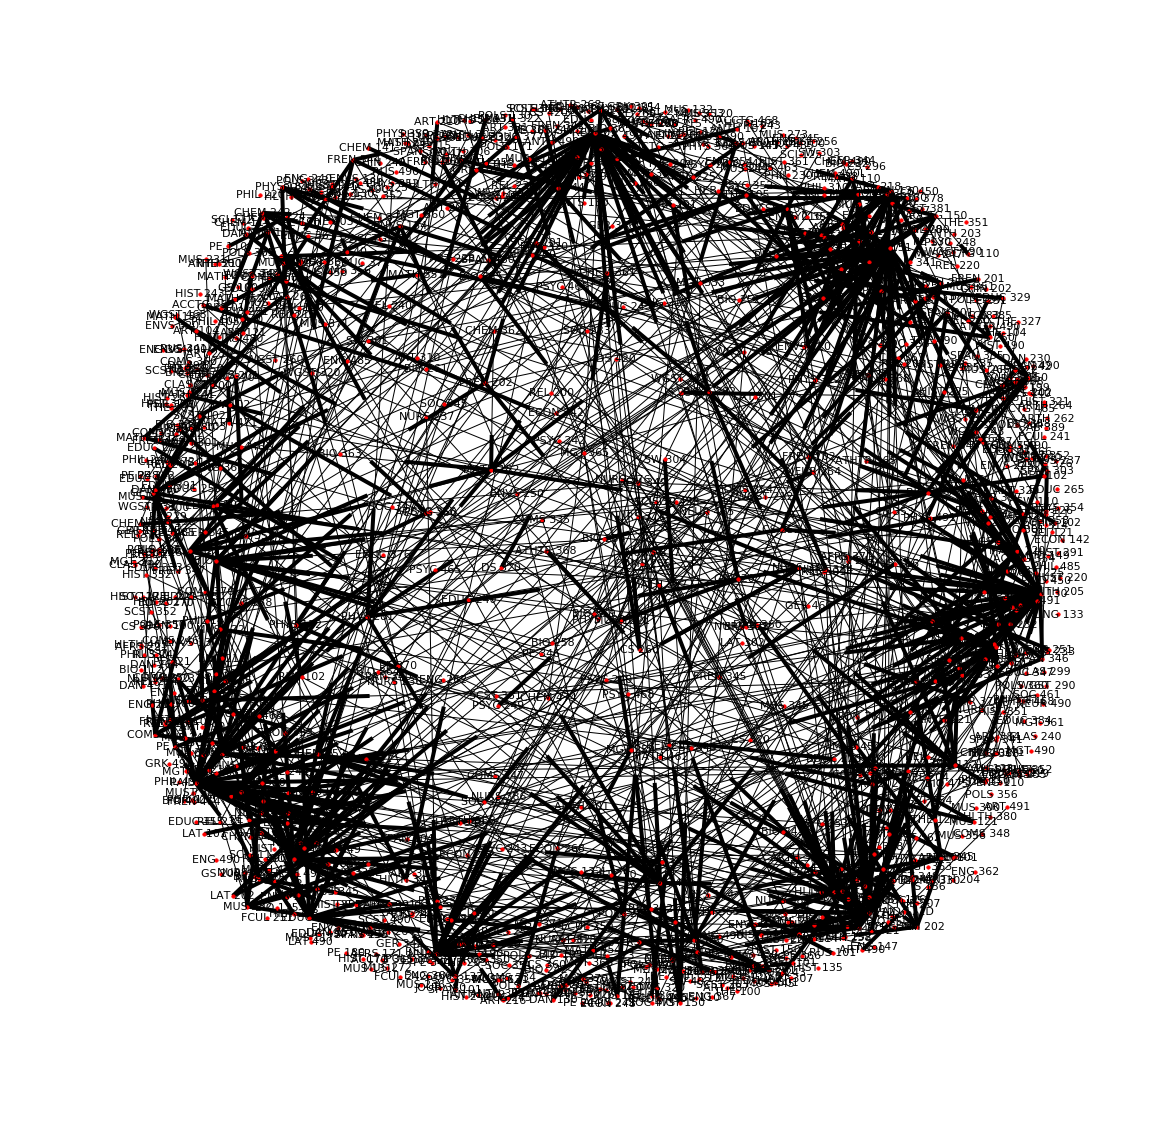

In [268]:
gfig, gax = plt.subplots(figsize=(20,20))
nx.draw(g,nx.spring_layout(g,k=0.4,iterations=35),ax=gax,with_labels=True,font_size=11,node_size=13)

In [328]:
sub_graph_dict = {}
for i in range(len(crs.index)):
    course_number = crs.loc[i].course_number
    prereq = crs.loc[i].Prerequisites
    dept = crs.loc[i].department
    class_format = re.compile('[A-Z]{2,5} \d{3}')
    lst = class_format.findall(prereq)
    edge_list = []
    for prrq in lst:
        g.add_edge(course_number,prrq)
        edge_list.append((course_number, prrq))
    if dept not in sub_graph_dict:
        sub_graph_dict[dept] = [edge_list]
    else:
        sub_graph_dict[dept].append(edge_list)

In [321]:
ok = {}
for deptment in sub_graph_dict:
    ok[deptment] = nx.DiGraph()
    for i in range(len(crs.index)):
        if crs.loc[i].department == deptment:
            ok[deptment].add_node(crs.loc[i].course_number)
    for item in sub_graph_dict[deptment]:
        if item != []:
            for tup in item:
                ok[deptment].add_edge(tup[0], tup[1])

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



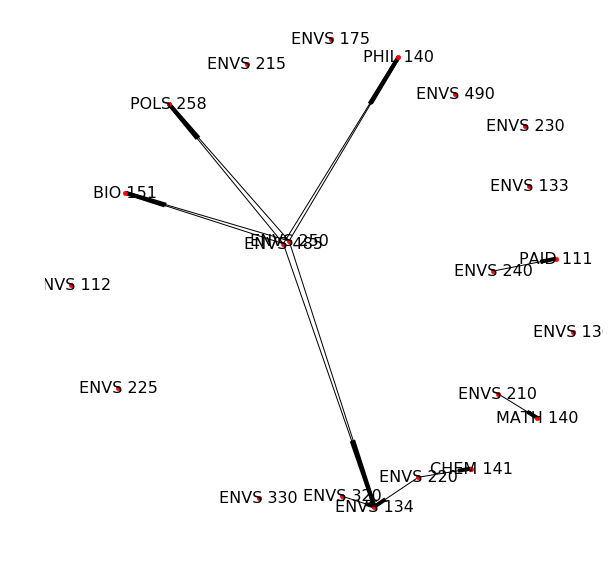

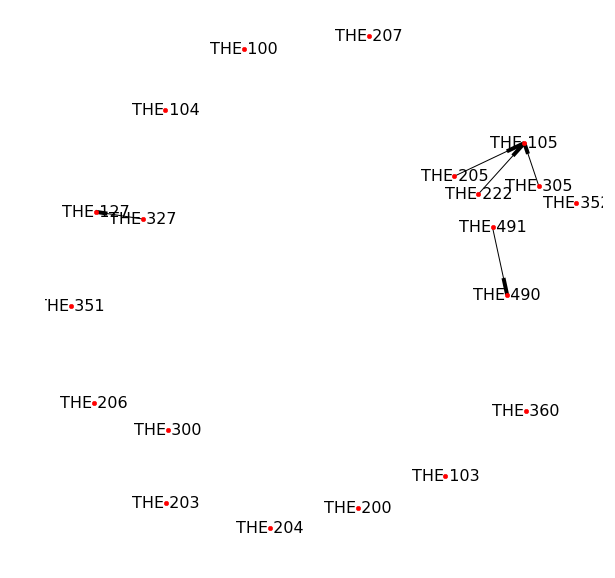

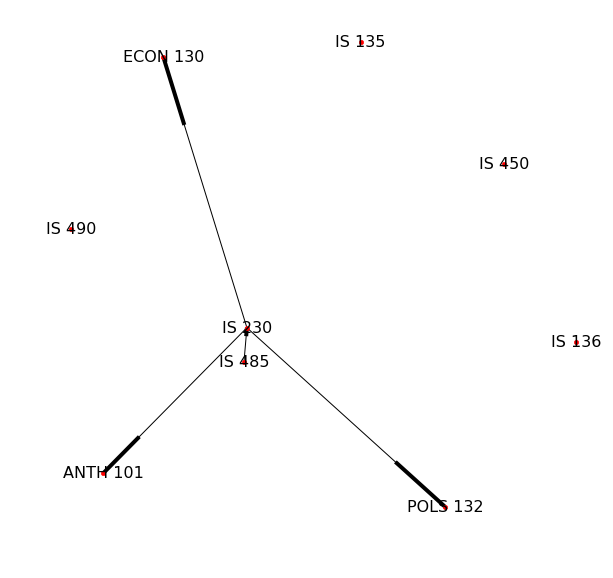

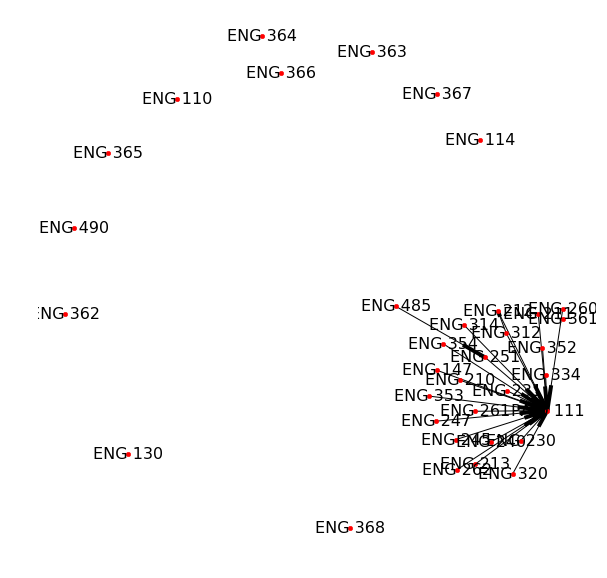

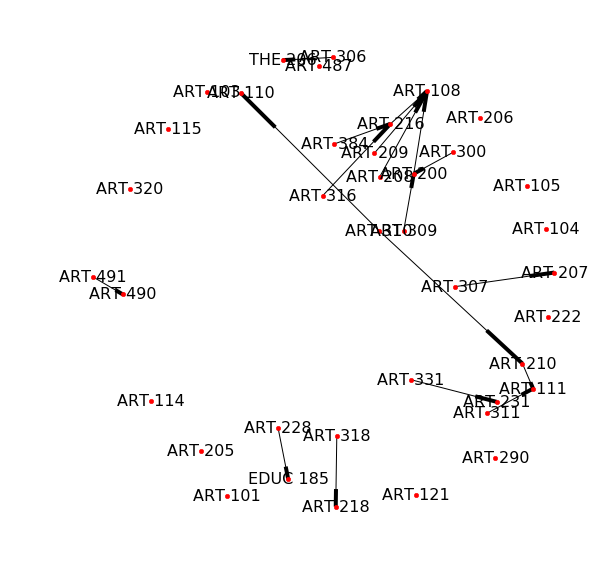

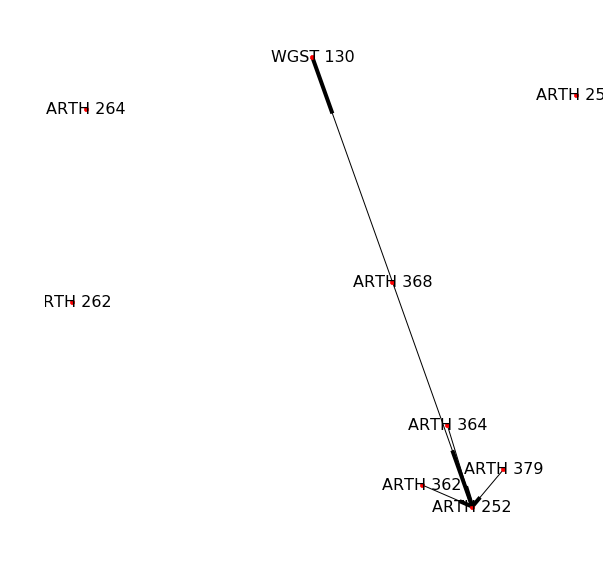

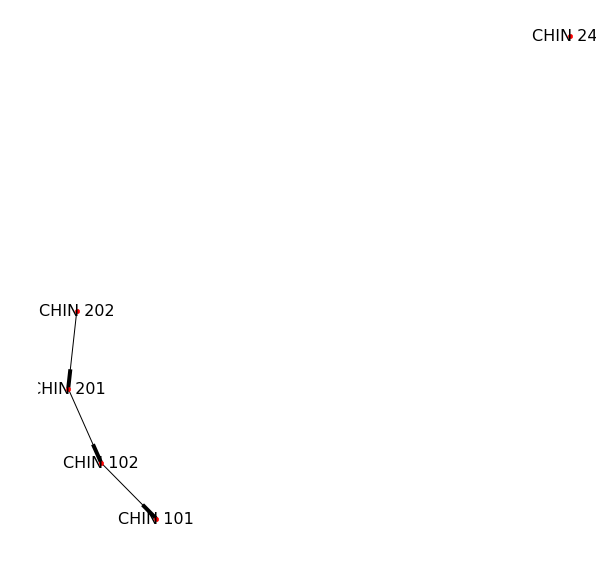

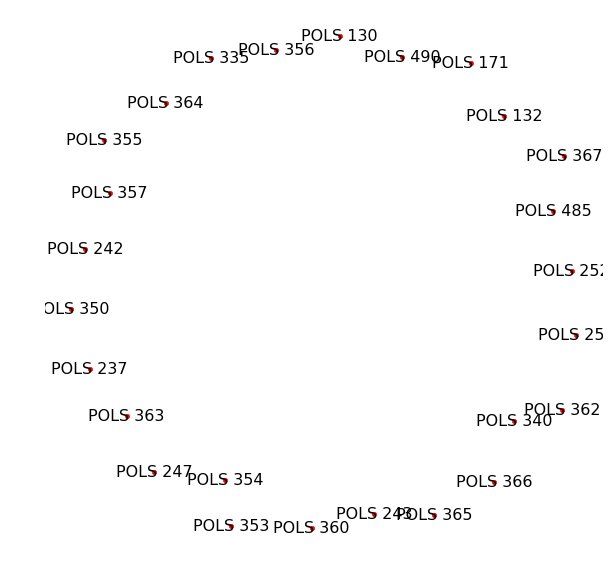

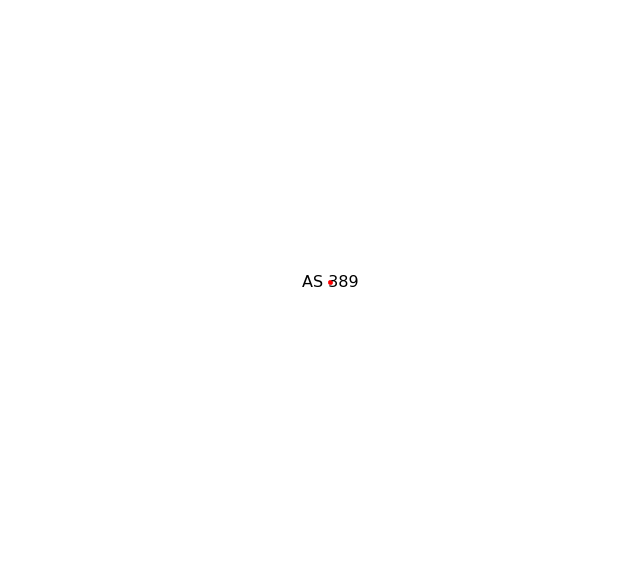

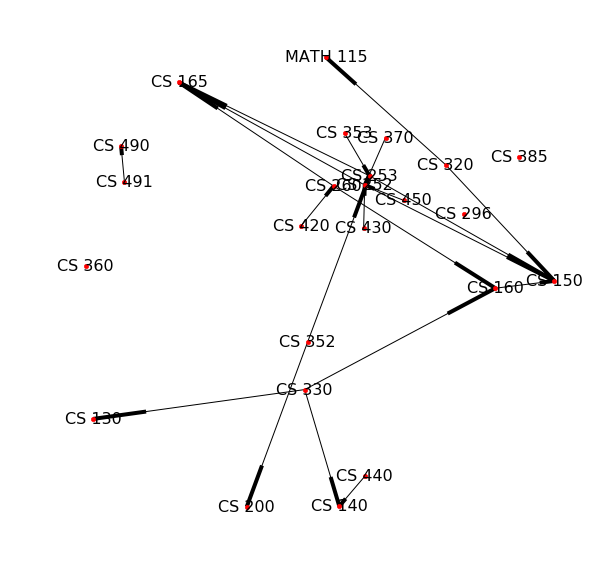

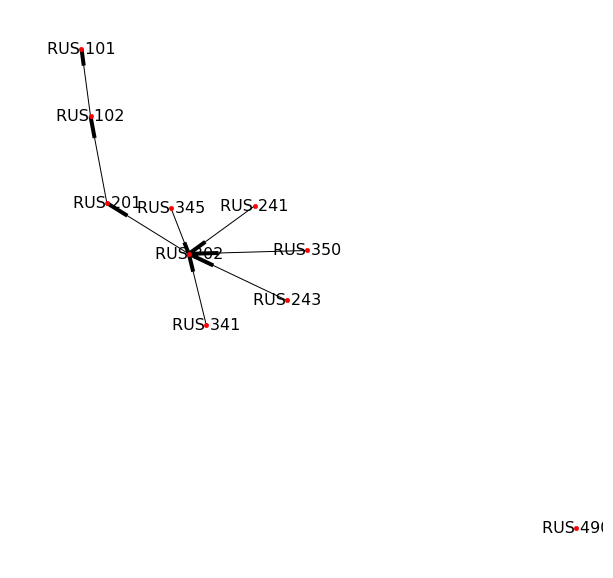

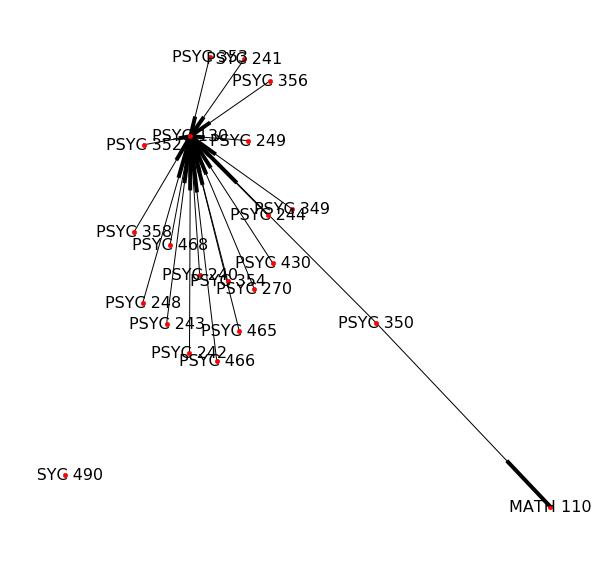

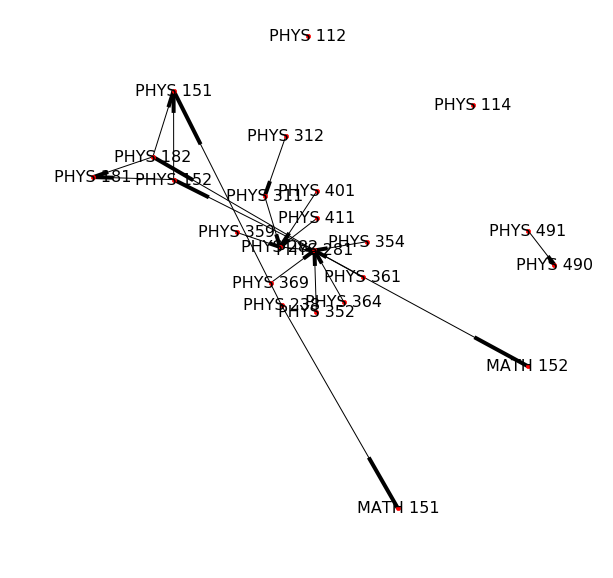

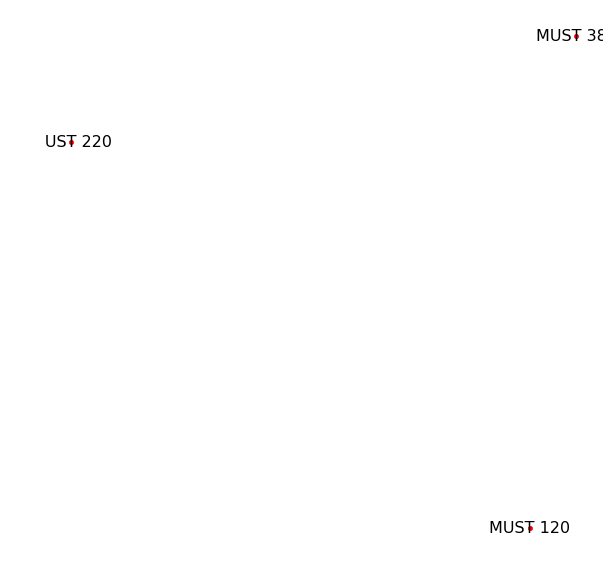

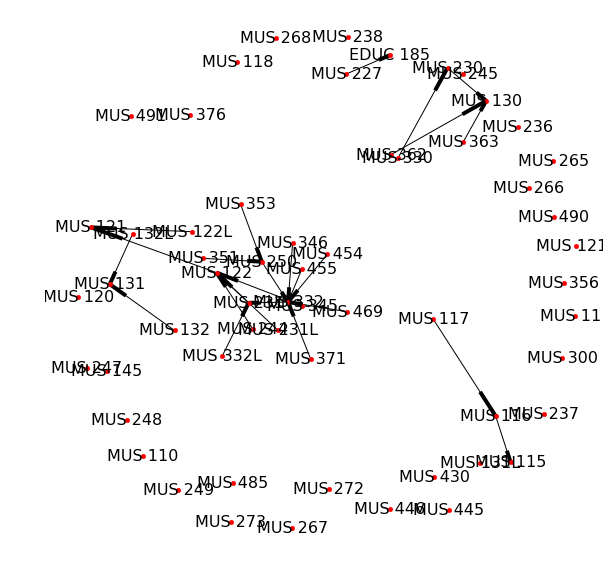

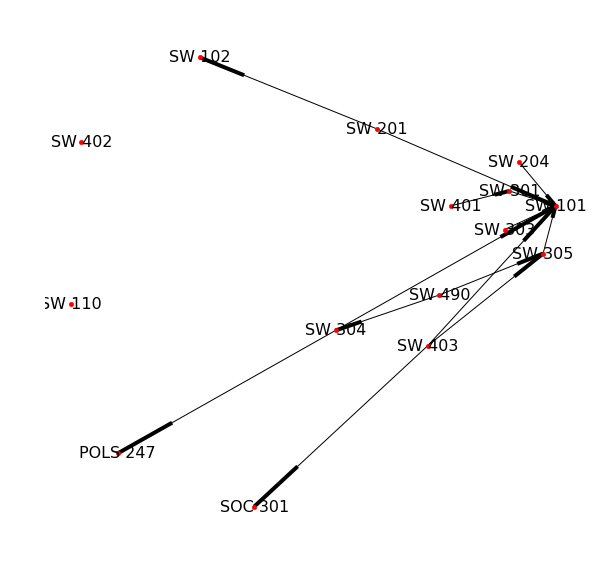

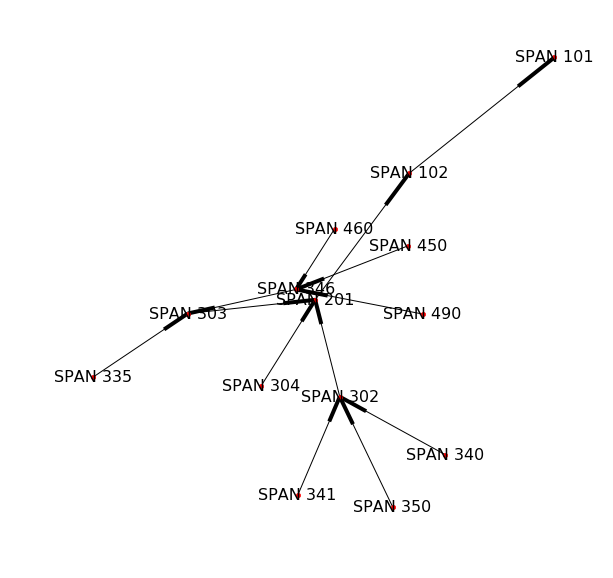

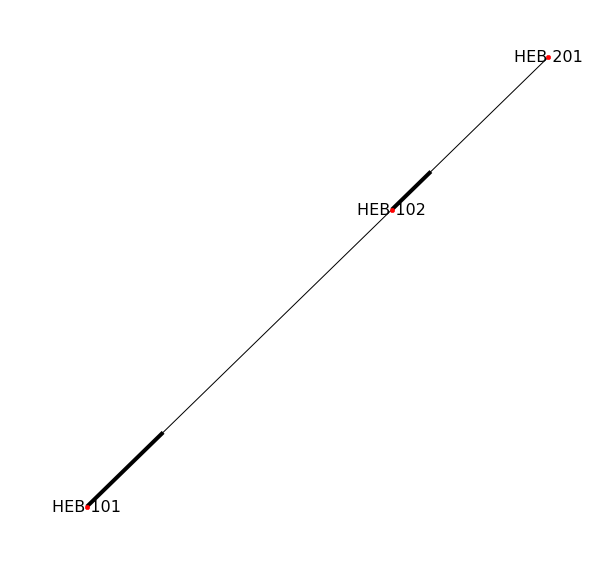

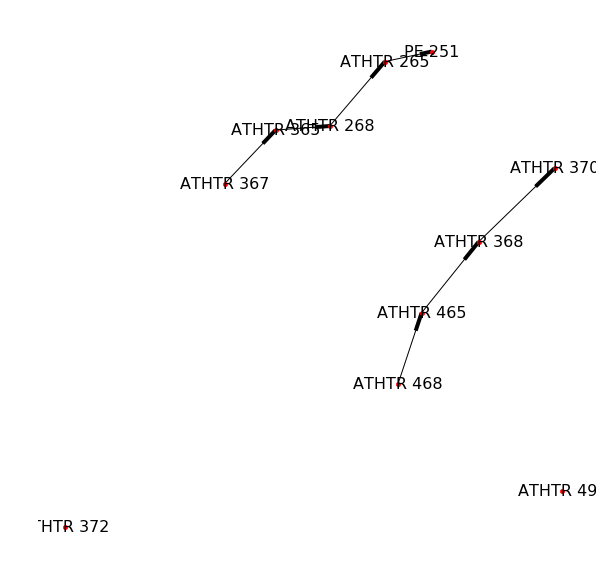

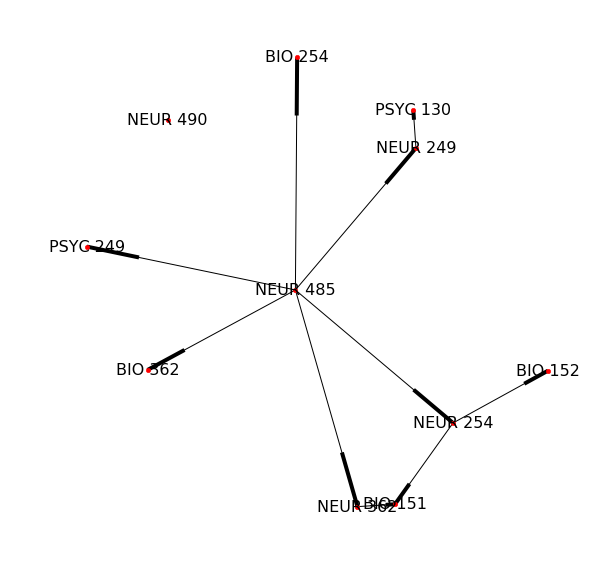

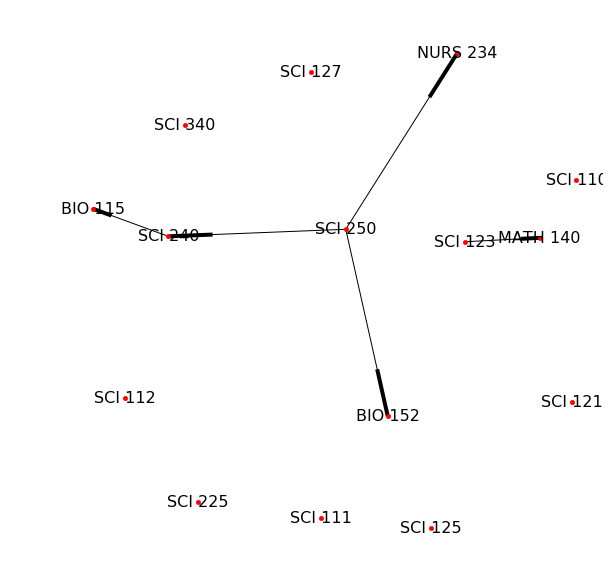

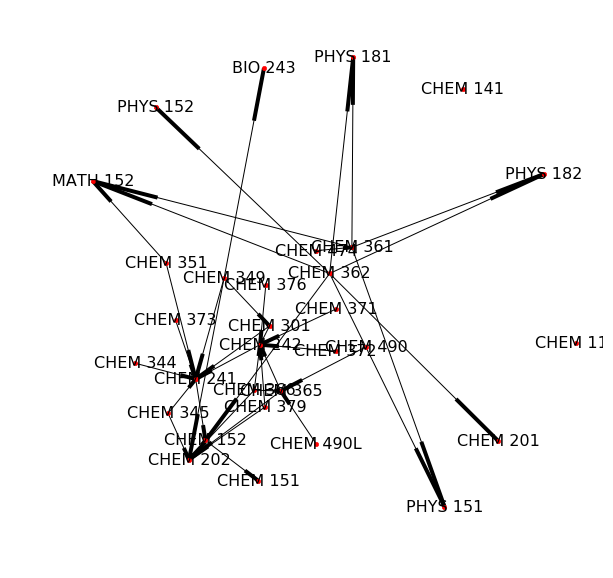

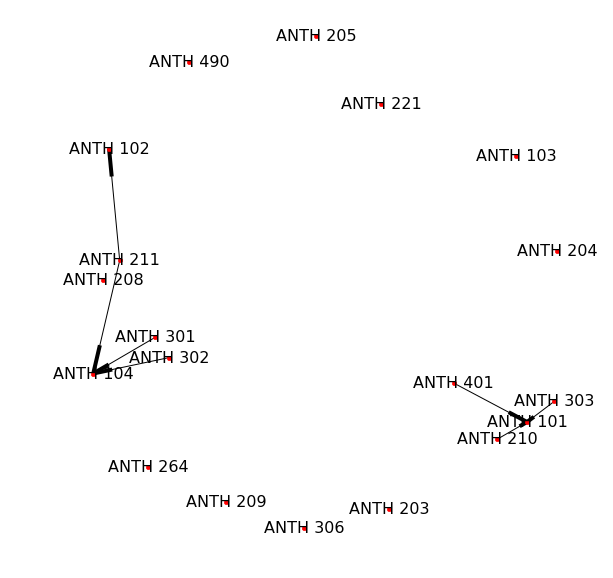

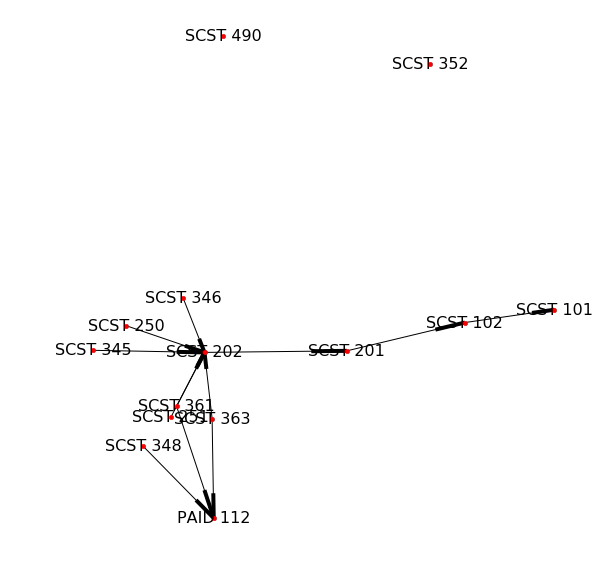

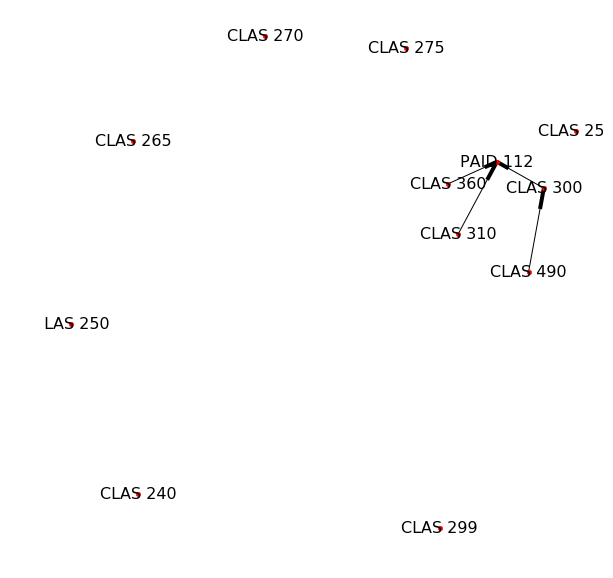

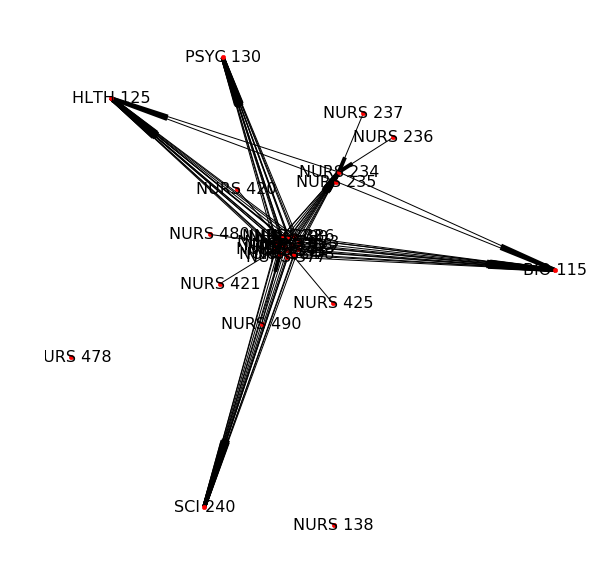

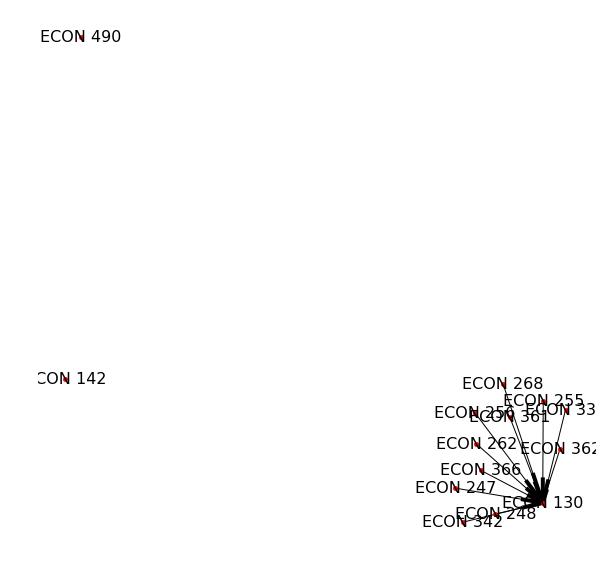

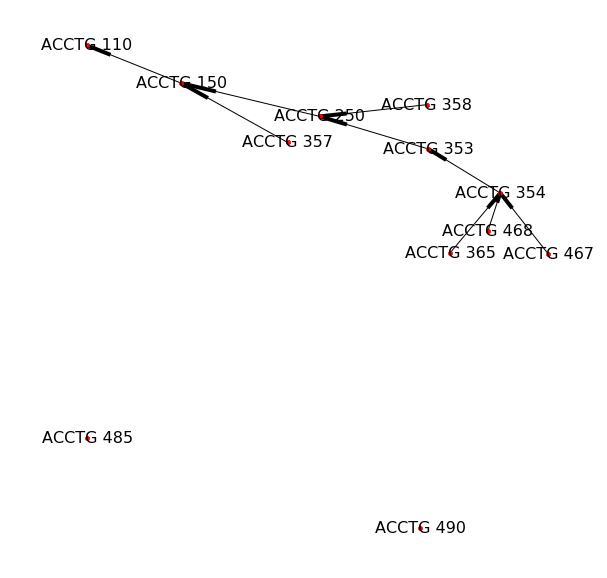

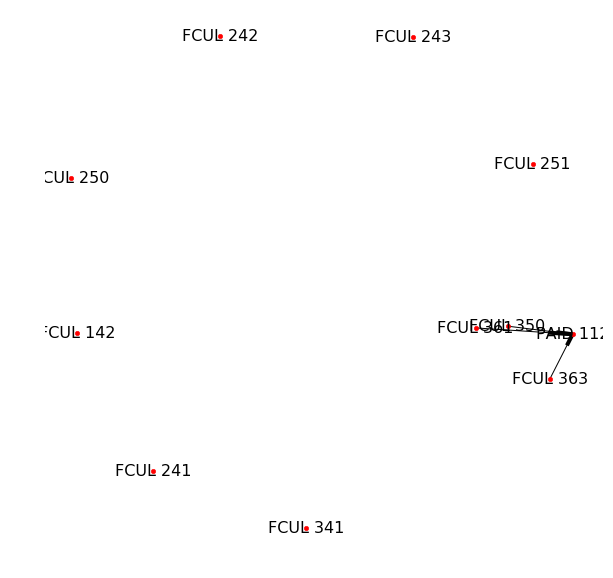

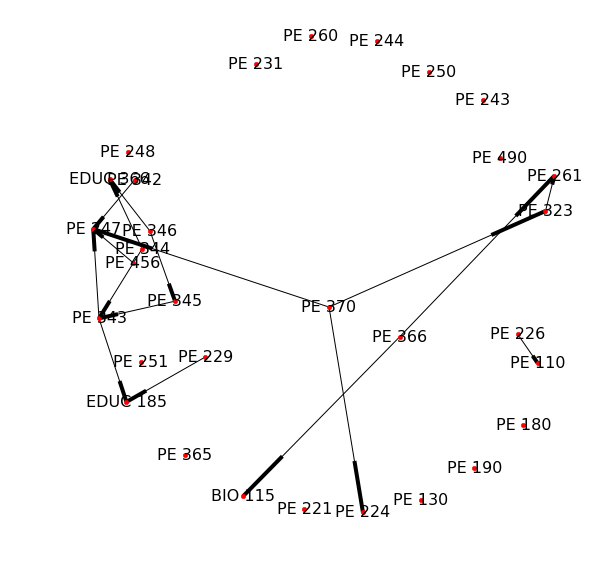

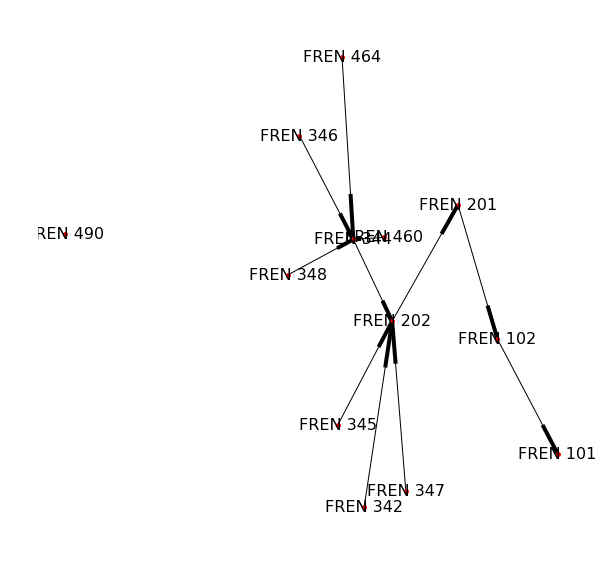

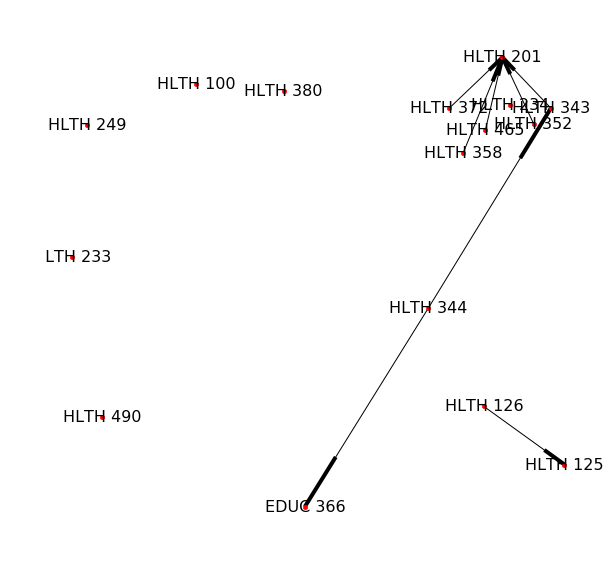

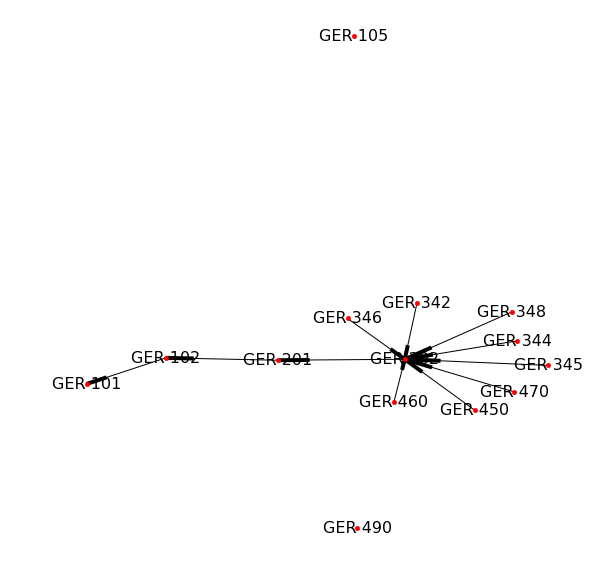

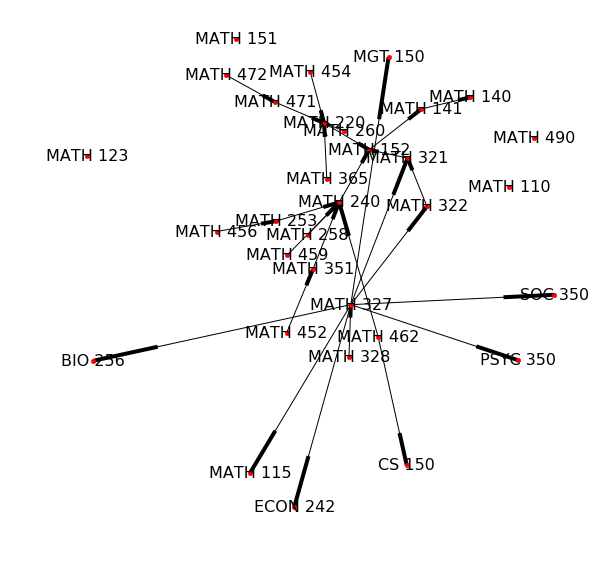

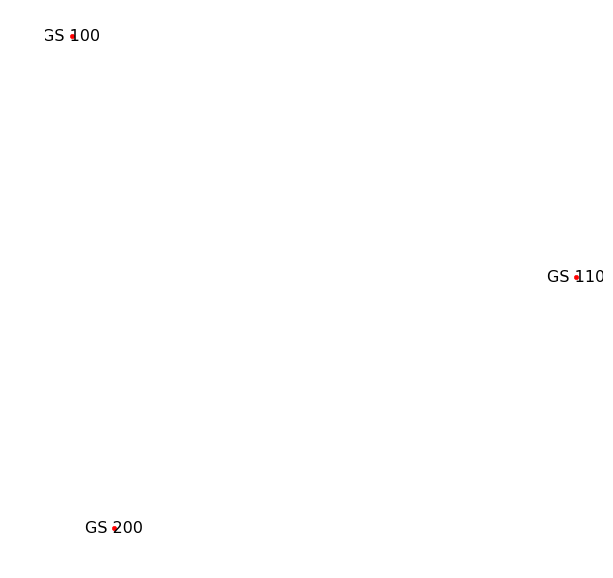

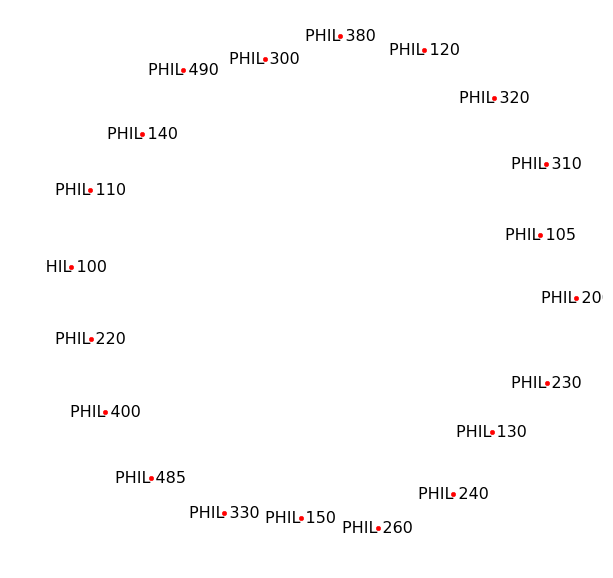

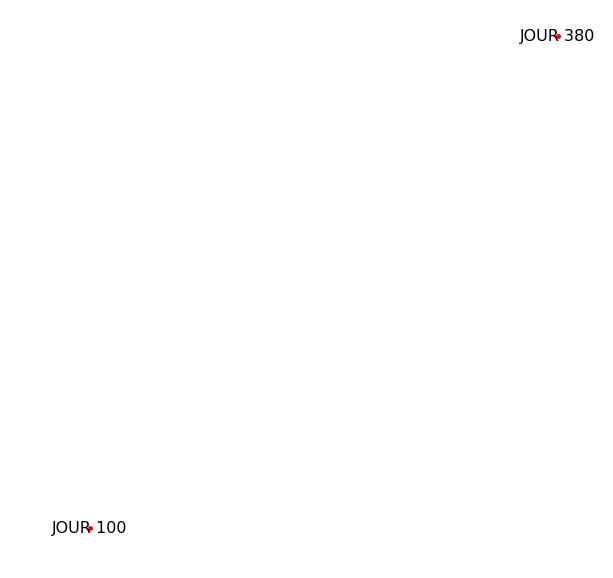

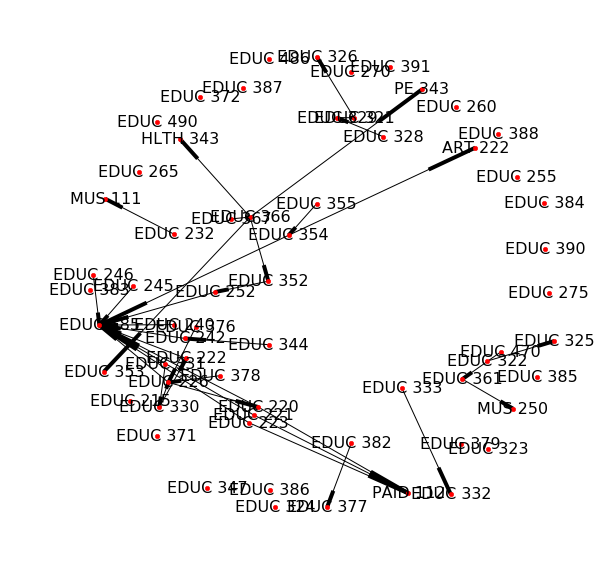

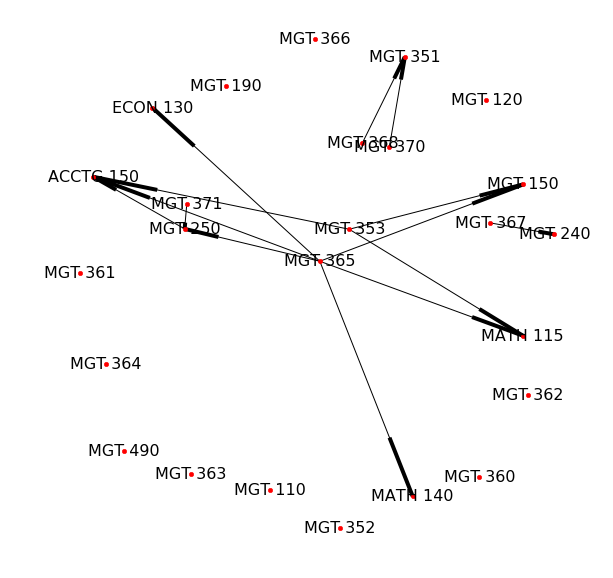

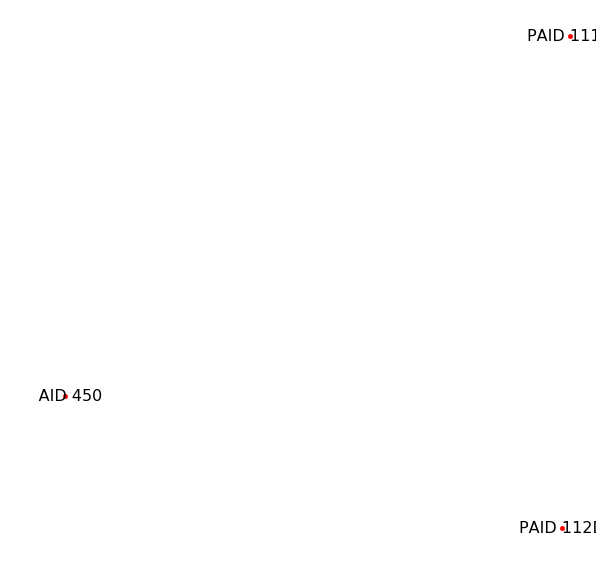

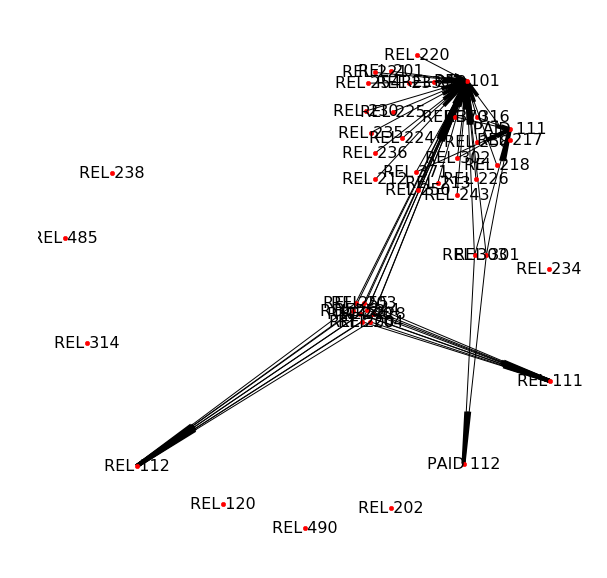

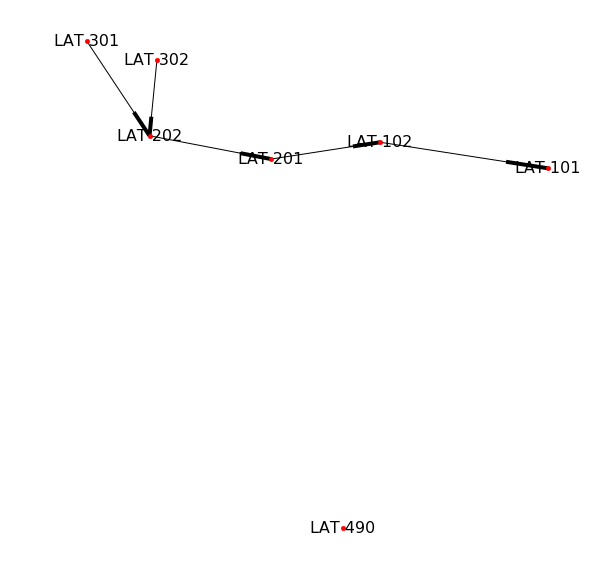

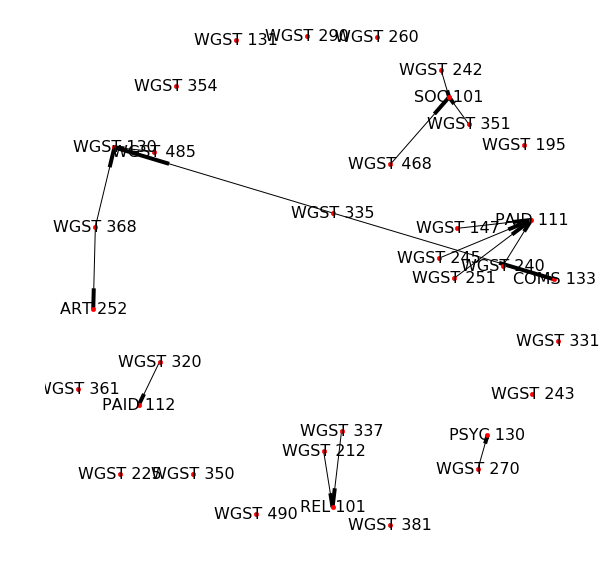

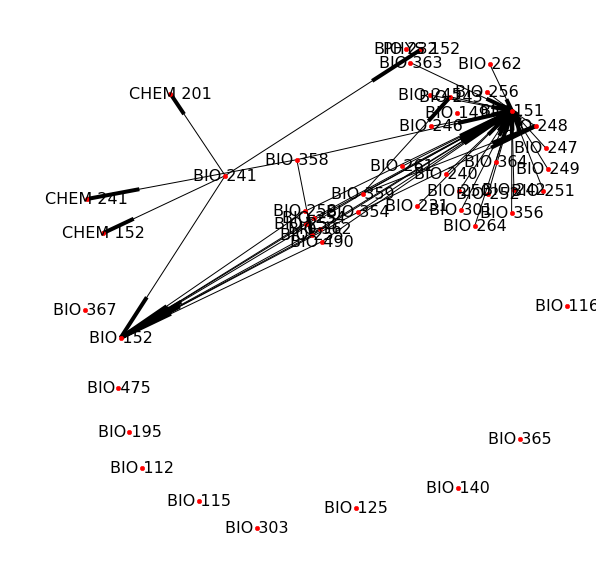

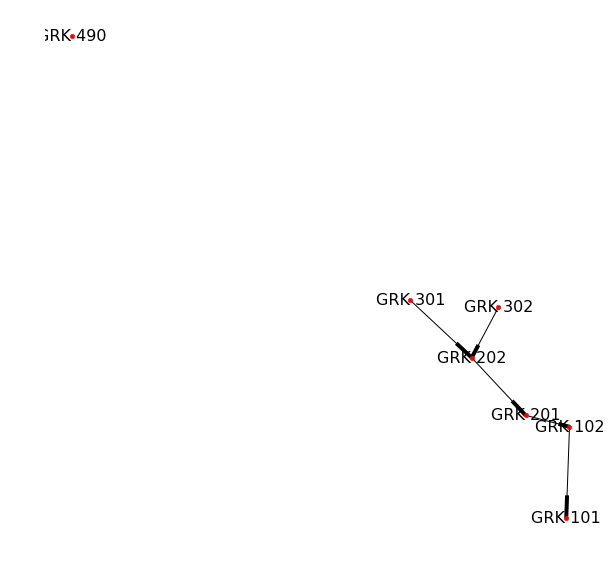

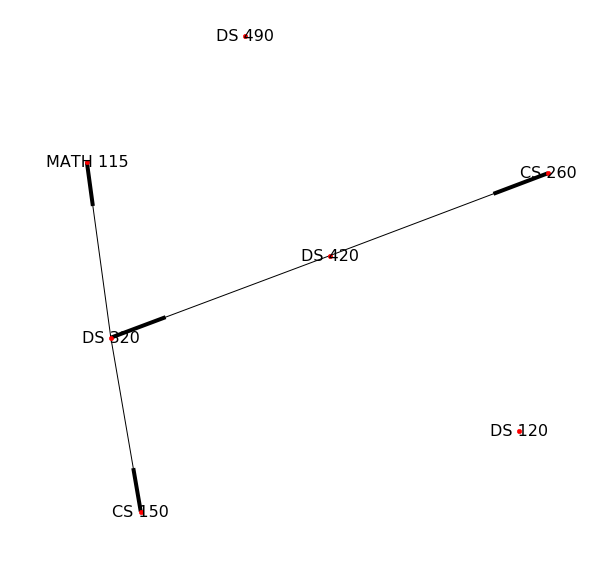

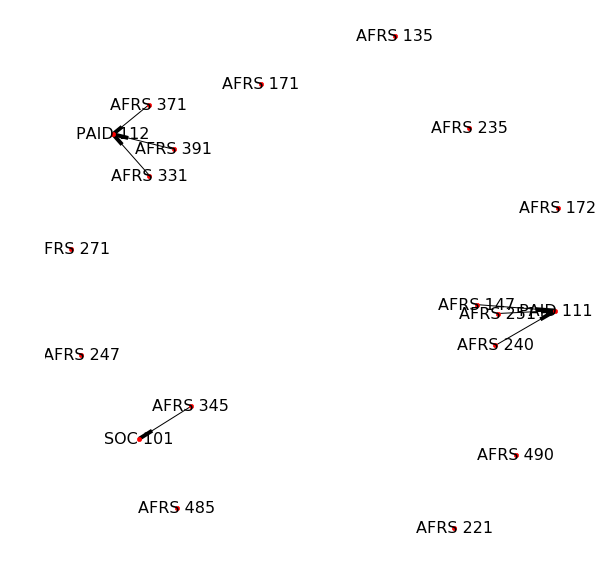

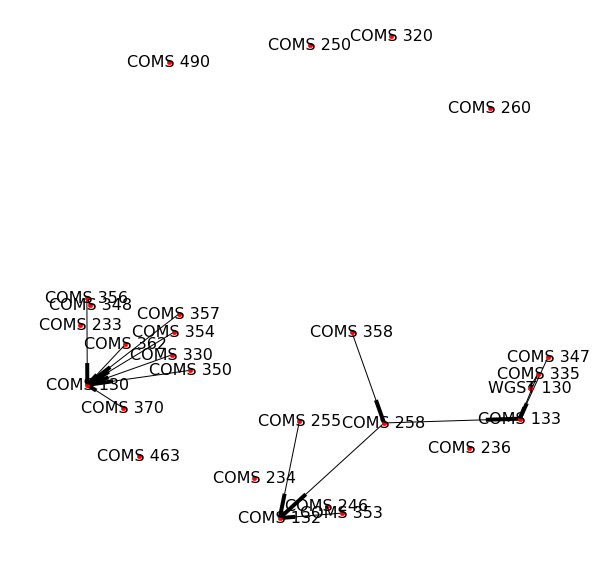

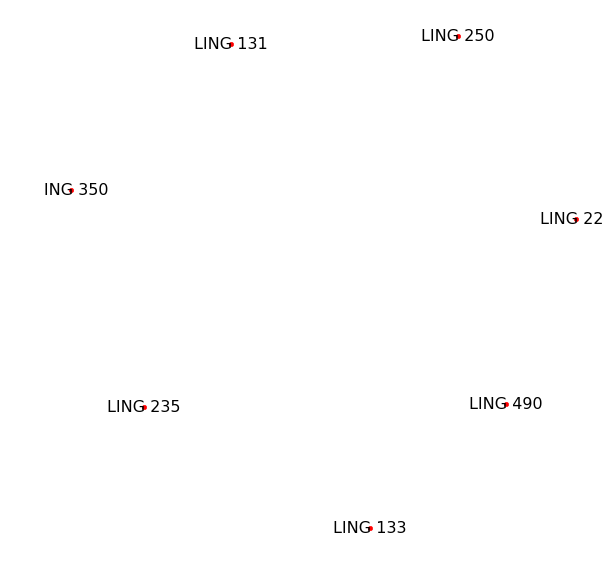

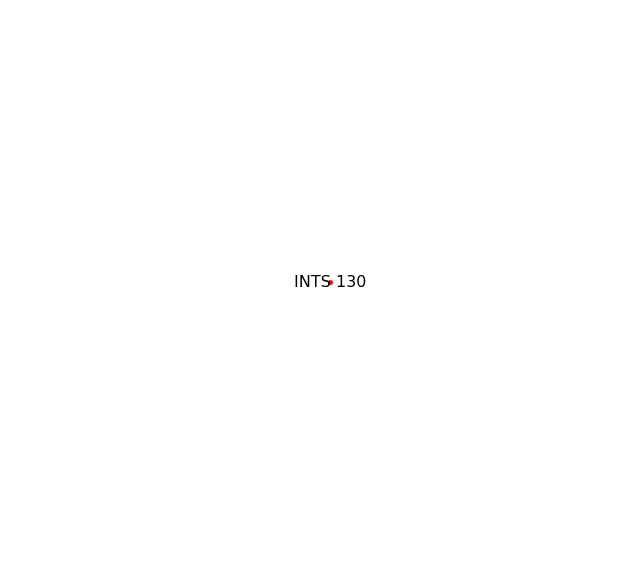

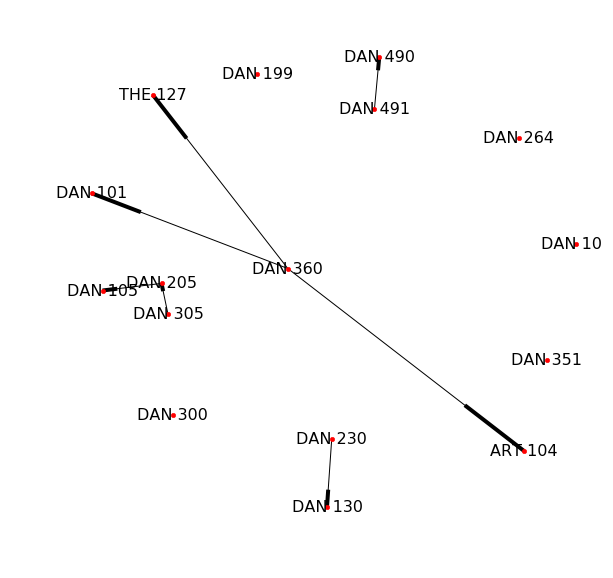

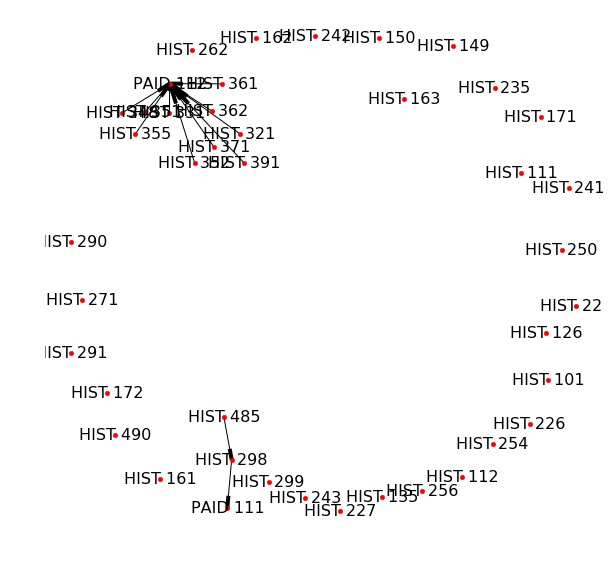

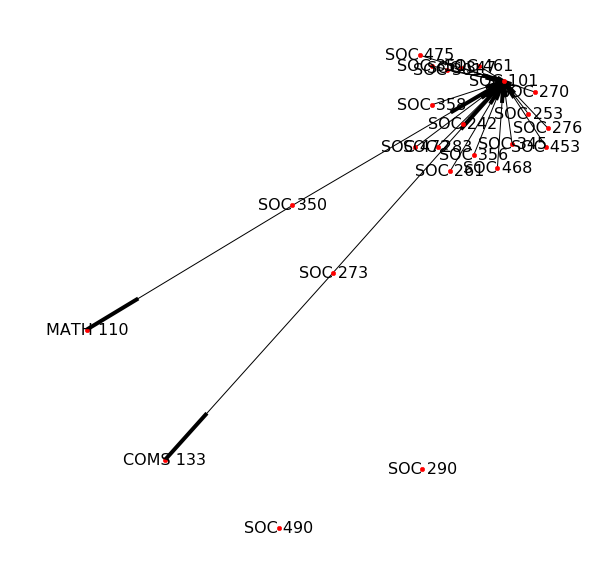

In [326]:
for dept in sub_graph_dict:
    gfig, gax = plt.subplots(figsize=(10,10))
    nx.draw(ok[dept],nx.spring_layout(ok[dept],k=0.4,iterations=60),ax=gax,with_labels=True,font_size=16,node_size=20)